## Расчет пары

In [1]:
# !pip install Shapely

In [2]:
from math import sin, cos, asin, pi, atan, exp, log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})
from copy import copy
from shapely.geometry import Polygon

In [3]:
def get_profile(Z, k, points):
    X_crd = []
    Y_crd = []
    kk = 2 * pi / Z
    
    for i in range(Z):
        for j in range(2*k):
            kk = 2*pi/Z
            R = (points[0][j] ** 2 + points[1][j] ** 2) ** 0.5
            a = asin(points[1][j] / R) + kk * (i-1)
            X = R * cos(a)
            Y = R * sin(a)
            X_crd.append(X)
            Y_crd.append(Y)

    return np.array([X_crd, Y_crd])

In [4]:
# ПАРАМЕТРЫ ДЛЯ ВВОДА

k = 20
Zd1 = 10  # количество зубьев статора
a = 3.4  # эксцентриситет (мм)
delta = 0  # натяг в паре (мм)
df1 = 82  # диаметр окружности впадин статора (мм)
S_OD = 121  # наружный диаметр статора, мм
S_ID = 95  # внутренний диаметр статора, мм
Spx = 160  # шаг статора, мм
Active_L = 5000  # мм
FlowHigh = 22  # л/с
FlowLow = 9  # л/с

In [5]:
# РАСЧЕТНЫЕ ПАРАМЕТРЫ

Zd2 = Zd1 - 1
r = 1.175 * a
rc = 2.175 * a
h = 2*a
k0 = k // 2 # div
sag1 = pi / (6*k0)
sag2 = (pi - pi/6) / k0

parent_list = np.ones(k)
parent_list_2 = np.ones(2*k)

Alphapt = copy(parent_list)
psi_p = copy(parent_list)
Xpt = copy(parent_list)
Ypt = copy(parent_list)
phid1 = copy(parent_list)
phid2 = copy(parent_list)
Xd1 = copy(parent_list_2)
Xd2 = copy(parent_list_2)
Yd1 = copy(parent_list_2)
Yd2 = copy(parent_list_2)

for i in range(k0):
    psi_p[i] = sag1 * i
    
    if psi_p[i] == 0:
        Alphapt[i]  = pi / 2
    else:
        Alphapt[i] = atan((r - a*cos(psi_p[i])) / (a * sin(psi_p[i])))

    Xpt[i] = (-1)*r + a*cos(psi_p[i]) + rc*sin(Alphapt[i])
    Ypt[i] = r*psi_p[i] - a*sin(psi_p[i]) + rc*cos(Alphapt[i])


for i in range(k0, k):

    psi_p[i] = k0 * sag1 + (i-k0) * sag2
    
    if psi_p[i] == 0:
        Alphapt[i] = pi / 2
    else:
        Alphapt[i] = atan((r - a*cos(psi_p[i])) / (a*sin(psi_p[i])))

    Xpt[i] = (-1)*r + a*cos(psi_p[i]) + rc*sin(Alphapt[i])
    Ypt[i] = r*psi_p[i] - a*sin(psi_p[i]) + rc*cos(Alphapt[i])

In [6]:
# ПРоверка коэфициента формы поверхности
T = Spx * Zd1
t = T * Zd2 / Zd1
print(T, t, Spx)
print(f't_min = {(5.5 * (df1 - a * 3)):.2f}, Rpx_min - не менее {(5.5 * (df1 - a * 3) / Zd2):.2f} ')
print(f't_max = {(12 * (df1 - a * 3)):.2f}, Rpx_max - не более {(12 * (df1 - a * 3) / Zd2):.2f}')

1600 1440.0 160
t_min = 394.90, Rpx_min - не менее 43.88 
t_max = 861.60, Rpx_max - не более 95.73


In [7]:
dw1 = 2*r*Zd1
dw2 = 2*r*Zd2
X1 = (df1-dw1)/2-h
X2 = X1 + r - a + delta / 2
# D1w1 = 2*a*Zd1
# D1w2 = 2*a*Zd2
# # Betaw = atan(2*pi*r/Px)
# # Betaw12 = atan(2*pi*a/Px)
da1 = dw1+2*X1
da2 = dw2+2*(h+X2)
df1 = dw1+2*(h+X1)
df2 = dw2+2*X2


for i in range(k-1, 2 * k):

    i_k = i-k
    k_i_1 = 2*k-i-1

    phid1[i_k] = 2 * ((Ypt[i_k] - (Xpt[i_k] + X1) * cos(Alphapt[i_k]) / sin(Alphapt[i_k])) / dw1)
    phid2[i_k] = 2 * ((Ypt[i_k] - (Xpt[i_k] + X2) * cos(Alphapt[i_k]) / sin(Alphapt[i_k])) / dw2)

    '''Вычисление координат Статора и Ротора'''

    Xd1[i] = (Xpt[i_k] + dw1 / 2 + X1) * cos(phid1[i_k]) - (Ypt[i_k] - dw1 * phid1[i_k] / 2) * sin(phid1[i_k])
    Xd2[i] = (Xpt[i_k] + dw2 / 2 + X2) * cos(phid2[i_k]) - (Ypt[i_k] - dw2 * phid2[i_k] / 2) * sin(phid2[i_k])
    Yd1[i] = (Xpt[i_k] + dw1 / 2 + X1) * sin(phid1[i_k]) + (Ypt[i_k] - dw1 * phid1[i_k] / 2) * cos(phid1[i_k])
    Yd2[i] = (Xpt[i_k] + dw2 / 2 + X2) * sin(phid2[i_k]) + (Ypt[i_k] - dw2 * phid2[i_k] / 2) * cos(phid2[i_k])

    Xd1[k_i_1] = Xd1[i]
    Yd1[k_i_1] = (-1) * Yd1[i]
    Xd2[k_i_1] = Xd2[i]
    Yd2[k_i_1] = (-1) * Yd2[i]

In [8]:
stat_coords = np.array([Xd1, Yd1])
rotor_coords = np.array([Xd2, Yd2])

# координаты для построения в инвенторе и для технологов
stator = get_profile(Zd1, k, stat_coords)
rotor = get_profile(Zd2, k, rotor_coords)

In [9]:
file_path = f'stat_crds_{S_OD}_{Zd2}-{Zd1}_{a}_{df1}_{Spx}_{Active_L}.xlsx'

stator_points = pd.DataFrame(stator.T, columns=['X', 'Y'])
stator_points = stator_points.round(3).drop_duplicates()
stator_points = stator_points.append(stator_points.loc[0], ignore_index=True)  # копируем первую точку в конец

stator_points.to_excel(file_path, index=False)

In [10]:
file_path = f'rotor_crds_{S_OD}_{Zd2}-{Zd1}_{a}_{df1}_{Spx}_{Active_L}.xlsx'

rotor_points = pd.DataFrame(rotor.T, columns=['X', 'Y'])
rotor_points = rotor_points.round(3).drop_duplicates()
rotor_points = rotor_points.append(rotor_points.loc[0], ignore_index=True)  # копируем первую точку в конец

rotor_points.to_excel(file_path, index=False)

In [11]:
# plt.plot(stator[0][range(3*k, 4*k)], stator[1][range(3*k, 4*k)])

In [12]:
Work_S = Polygon(stator.T).area - Polygon(rotor.T).area
Work_S

762.3859920233599

In [13]:
VolPerRev = Zd2**2 * Spx * Work_S / 1.0e6
VolPerRev

9.880522456622744

In [14]:
speed_max = FlowHigh *.83 / VolPerRev
speed_min = FlowLow / VolPerRev
RPM_max = speed_max * 60
RPM_min = speed_min * 60
print(f'RPM_max = {RPM_max:.1f}')
print(f'RPM_min = {RPM_min:.1f}')

RPM_max = 110.9
RPM_min = 54.7


In [15]:
da2

75.19999999999999

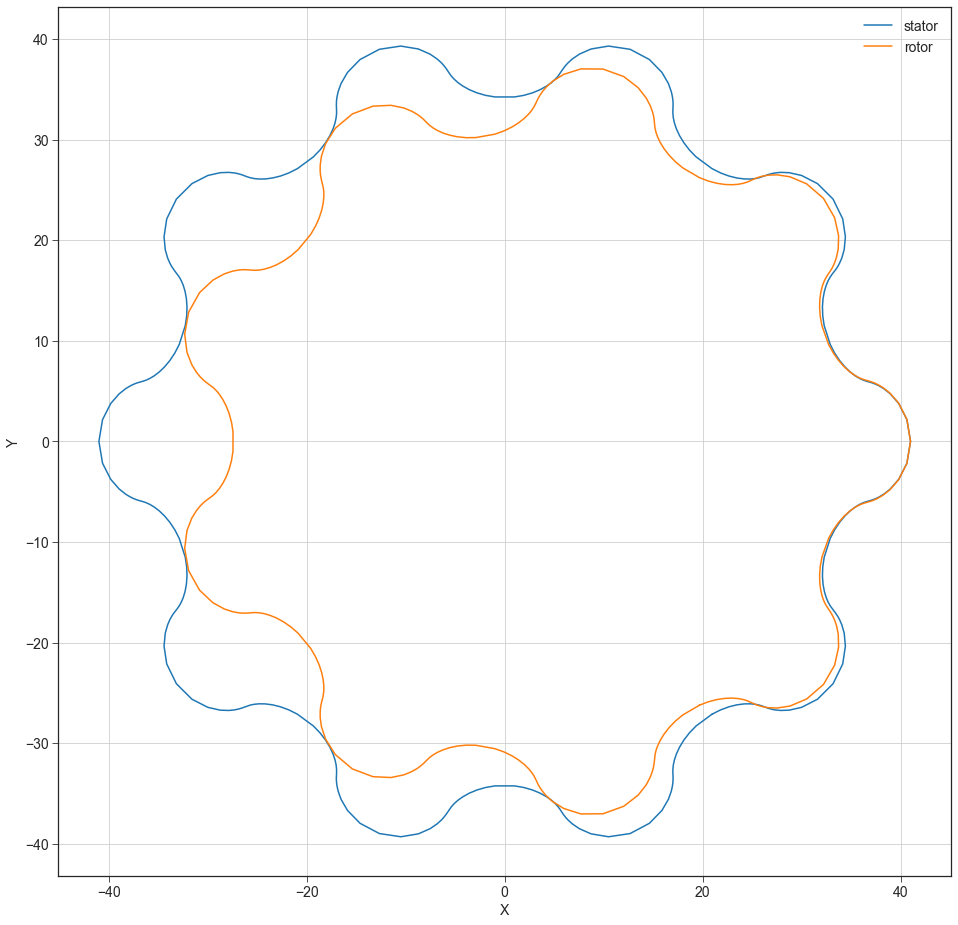

In [16]:
plt.figure(figsize = (16, 16))
plt.plot(stator_points['X'], stator_points['Y'], label='stator')
plt.plot(rotor_points['X'] + a, rotor_points['Y'], label='rotor')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

plt.savefig("test_ost.svg", format="svg", dpi=1200)